<a href="https://colab.research.google.com/github/rfaoktvian/AnalisisSentimenDebatCapres2024/blob/main/Analisis_sentimen_debat_capres2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.5 MB/s eta 0:00:00


In [3]:
import os, csv, requests, re, nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from googleapiclient.discovery import build
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC


# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv('youtube_comments_debat_capres2024.csv')
df.head(100)

,comment_text,like_count,reply_count,published_at
0,Menjatuhkan kinerja seseorg dipublik sama dgñ ...,1,0,2026-01-21T17:42:14Z
1,Aku terbangun jam 2 mlm tiba2 ingat debat ini,1,0,2026-01-15T19:17:31Z
2,this year everything is proven,2,0,2026-01-14T05:12:17Z
3,"gua balik lagi kesini, gara gara konoha mulai ...",12,2,2025-12-20T16:19:49Z
4,Hanya Pak Anis yg bahas isu lingkungan di deba...,4,0,2025-12-14T12:47:20Z
...,...,...,...,...
95,"Kayak nyari"" kesalahan",0,0,2024-02-17T14:35:40Z
96,Ini Anis parah banget terlalu menyerang pribad...,0,0,2024-02-17T14:30:53Z
97,Flash back liat debat presiden ini\n01 & 03 pr...,0,0,2024-02-17T14:28:24Z
98,"Ini Anis ngapain nanyak pribadi ya ,kampret bnget",0,0,2024-02-17T12:30:33Z


In [5]:
df.shape

(10930, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10930 entries, 0 to 10929
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment_text  10930 non-null  object
 1   like_count    10930 non-null  int64 
 2   reply_count   10930 non-null  int64 
 3   published_at  10930 non-null  object
dtypes: int64(2), object(2)
memory usage: 341.7+ KB


In [7]:
clean_df = df.drop_duplicates()

In [8]:
clean_df.duplicated().sum()

np.int64(0)

In [9]:
# Text Preprocessing

def cleaningText(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)
  text = re.sub(r'#[A-Za-z0-9]+', '', text)
  text = re.sub(r'RT[\s]', '', text)
  text = re.sub(r"http\S+", '', text)
  text = re.sub(r'[0-9]+', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = text.replace('\n', ' ')
  text = text.strip(' ')
  return text

slangwords = {
    "abis": "habis",
    "bgt": "banget",
    "bangettt": "banget",
    "bgtt": "banget",
    "gk": "tidak",
    "ga": "tidak",
    "gak": "tidak",
    "nggak": "tidak",
    "enggak": "tidak",
    "tdk": "tidak",
    "dr": "dari",
    "dri": "dari",
    "aja": "saja",
    "udh": "sudah",
    "udah": "sudah",
    "blm": "belum",
    "belom": "belum",
    "pdhl": "padahal",
    "krn": "karena",
    "sm": "sama",
    "jg": "juga",
    "tp": "tapi",
    "trs": "terus",
    "org": "orang",
    "kmrn": "kemarin",
    "skrg": "sekarang",
    "omon": "bicara",
    "sory": "sorry",
    "sori": "sorry",
    "anis": "anies",
    "kren": "keren",
    "sy": "saya",
    "sya": "saya",
    "nnti": "nanti",
    "yg": "yang",
    "dgn": "dengan",
    "sdh": "sudah",
    "pd": "pada",
    "bs": "bisa",
    "klo": "kalau",
    "kalo": "kalau",
    "kl": "kalau",
    "msh": "masih",
    "lg": "lagi",
    "jd": "jadi",
    "nih": "ini",
    "tuh": "itu",
    "kyk": "seperti",
    "kayak": "seperti",
    "gw": "saya",
    "gua": "saya",
    "lu": "kamu",
    "lo": "kamu",
    "tau": "tahu",
    "cm": "cuma",
    "dlm": "dalam",
    "gemoy": "gemas",
    "ny": "nya",
    "anie": "anies",
    "mani": "manis",
    "utk": "untuk",
    "pa": "bapak",
    "p": "bapak",
    "tpi": "tapi",
    "dah": "sudah",
    "jgn": "jangan",
    "bpk": "bapak",
    "karna": "karena",
    "pinter": "pintar",
    "capre": "capres",
    "liat": "lihat",
    "jdi": "jadi",
    "kali": "mungkin",
    "bagu": "bagus",
    "pk": "pak",
    "ni": "ini",
    "g" : "tidak",



}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word in slangwords:
            fixed_words.append(slangwords[word])
        else:
            fixed_words.append(word)

    return " ".join(fixed_words)

def casefoldingText(text):
    text = text.lower()
    return text

def tokenizingText(text):
    text = word_tokenize(text)
    return text

def filteringText(tokens):
    stop_id = set(stopwords.words('indonesian'))
    stop_en = set(stopwords.words('english'))

    negation_words = {"tidak", "bukan", "jangan", "nggak", "enggak"}

    stopwords_all = (stop_id | stop_en) - negation_words

    custom_stopwords = {
        "iya","yaa","sih","loh","kah","woi","woii","woy",
        "nya","ku","di","ke","dari"
    }

    stopwords_all.update(custom_stopwords)

    return [word for word in tokens if word not in stopwords_all]

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemmingText(text):
    return stemmer.stem(text)


In [10]:

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def preprocess_wrapper(text):
    if not isinstance(text, str):
        return ""

    text = cleaningText(text)
    text = casefoldingText(text)
    text = fix_slangwords(text)
    tokens = tokenizingText(text)
    tokens = filteringText(tokens)
    sentence = toSentence(tokens)
    # Stemming opsional: aktifkan jika butuh akurasi lebih tapi siap menunggu lama
    # sentence = stemmingText(sentence)
    return sentence

clean_df['final_text'] = clean_df['comment_text'].apply(preprocess_wrapper)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-703599033.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['final_text'] = clean_df['comment_text'].apply(preprocess_wrapper)


In [11]:
print(clean_df[['comment_text', 'final_text']].head())

                                        comment_text  \
0  Menjatuhkan kinerja seseorg dipublik sama dgñ ...   
1      Aku terbangun jam 2 mlm tiba2 ingat debat ini   
2                     this year everything is proven   
3  gua balik lagi kesini, gara gara konoha mulai ...   
4  Hanya Pak Anis yg bahas isu lingkungan di deba...   

                                          final_text  
0  menjatuhkan kinerja seseorg dipublik dgñ menja...  
1                            terbangun jam mlm debat  
2                             year everything proven  
3          kesini gara gara konoha hancur berantakan  
4  anies bahas isu lingkungan debat capres haya t...  


In [12]:
from io import StringIO


lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')


if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')

    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')

if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter=',')
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [13]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text.split():
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    if score > 0:
        polarity = "positive"
    elif score < 0:
        polarity = "negative"
    else:
        polarity = "neutral"

    return score, polarity

In [14]:
results = clean_df['final_text'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['polarity'] = results[1]

/tmp/ipython-input-2166883952.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity_score'] = results[0]
/tmp/ipython-input-2166883952.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['polarity'] = results[1]


In [15]:
print(clean_df['polarity'].value_counts())
print(clean_df['polarity'].value_counts(normalize=True))


polarity
positive    5333
negative    3141
neutral     2447
Name: count, dtype: int64
polarity
positive    0.488325
negative    0.287611
neutral     0.224064
Name: proportion, dtype: float64


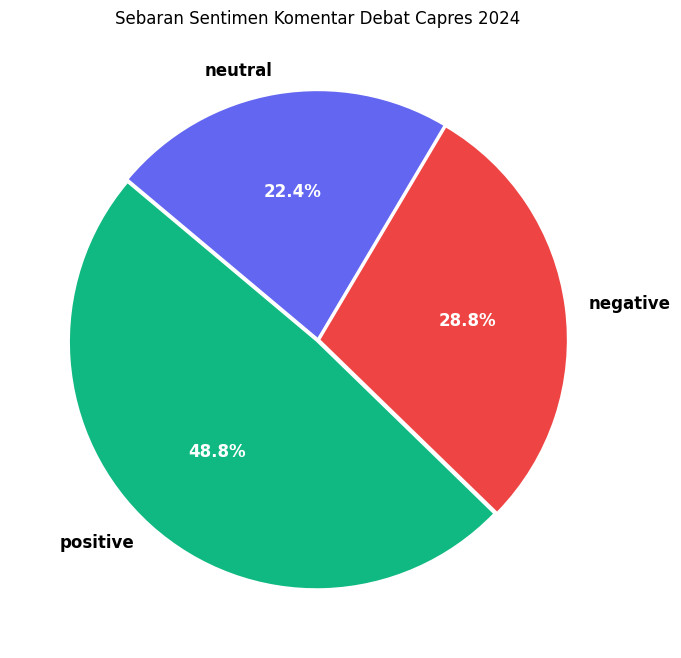

Jumlah Komentar Per Kategori:
polarity
positive    5333
negative    3141
neutral     2447
Name: count, dtype: int64


In [44]:
sentiment_counts = clean_df['polarity'].value_counts()

colors = ['#10b981', '#ef4444', '#6366f1']
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=(0.01, 0.01, 0.01),
    textprops={'fontsize': 12, 'weight': 'bold'}
)
for text in plt.gca().texts:
    if '%' in text.get_text():
        text.set_color('white')
        text.set_weight('bold')
plt.title('Sebaran Sentimen Komentar Debat Capres 2024')
plt.show()
print("Jumlah Komentar Per Kategori:")
print(sentiment_counts)

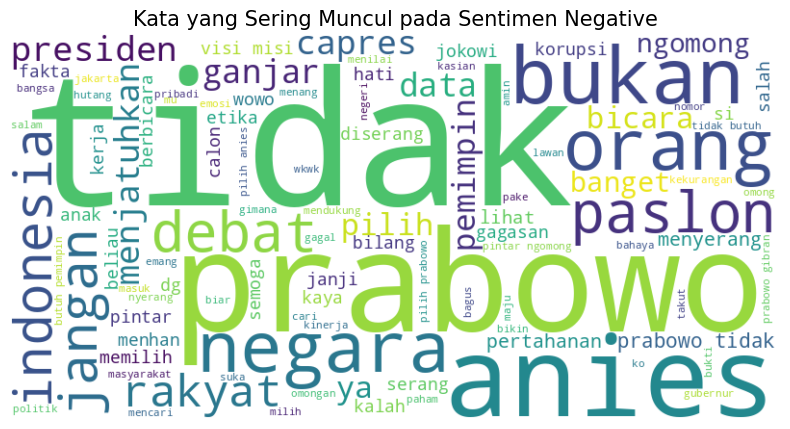

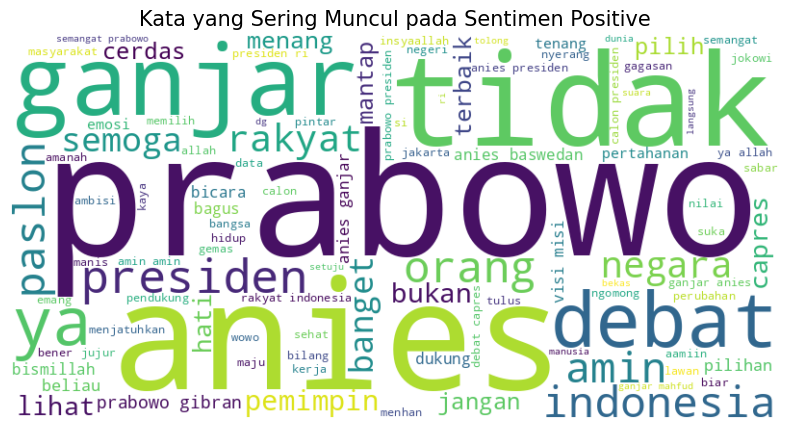

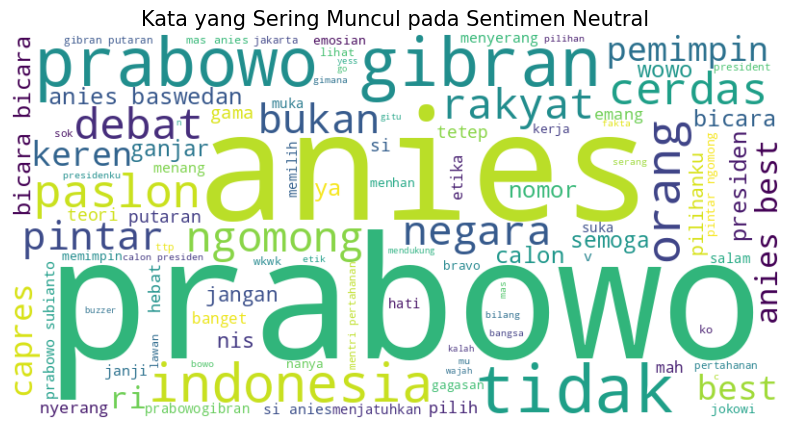

In [17]:
from wordcloud import WordCloud

def show_wordcloud(sentiment):

    text = " ".join(clean_df[clean_df['polarity'] == sentiment]['final_text'])

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(text)


    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Kata yang Sering Muncul pada Sentimen {sentiment.capitalize()}', fontsize=15)
    plt.axis('off')
    plt.show()


for label in clean_df['polarity'].unique():
    show_wordcloud(label)

In [18]:
X_text = clean_df['final_text']
y_label = clean_df['polarity']

In [19]:
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_text,
    y_label,
    test_size=0.2,
    random_state=42,
    stratify=y_label
)

In [20]:
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = tfidf.fit_transform(X_train_ml)
X_test_tfidf  = tfidf.transform(X_test_ml)

In [21]:
model4 = MultinomialNB()
model4.fit(X_train_tfidf, y_train_ml)

y_pred = model4.predict(X_test_tfidf)
accuracy = accuracy_score(y_test_ml, y_pred)
print("Test Accuracy Model Naive Bayes:", accuracy)

Test Accuracy Model Naive Bayes: 0.6919908466819222


In [22]:
count_vect = CountVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_count = count_vect.fit_transform(X_train_ml)
X_test_count  = count_vect.transform(X_test_ml)


In [23]:
model5 = LinearSVC()
model5.fit(X_train_count, y_train_ml)

y_pred_svm = model5.predict(X_test_count)

print("Test Accuracy SVM:", accuracy_score(y_test_ml, y_pred_svm))
print(classification_report(y_test_ml, y_pred_svm))
print(confusion_matrix(y_test_ml, y_pred_svm))

Test Accuracy SVM: 0.8466819221967964
              precision    recall  f1-score   support

    negative       0.83      0.79      0.81       628
     neutral       0.76      0.84      0.79       490
    positive       0.90      0.88      0.89      1067

    accuracy                           0.85      2185
   macro avg       0.83      0.84      0.83      2185
weighted avg       0.85      0.85      0.85      2185

[[495  71  62]
 [ 39 411  40]
 [ 61  62 944]]


In [24]:
# Error Analysis
error_df = pd.DataFrame({
    "text": X_test_ml,
    "true_label": y_test_ml,
    "pred_label": y_pred_svm
})

error_df.head()

,text,true_label,pred_label
4125,pasangan capres cawapres ganjarmahfud cocok nkri,positive,positive
6339,menghalalkan dasar anies beda kelas prabowo pa...,negative,negative
3375,anies medali emas prabowo medali perak ganjar ...,positive,positive
6595,paslon tidak omongannya sumber keyaan bosen nn,negative,negative
5953,pandang mudah manusia menjatuhkan individu kat...,negative,positive


In [25]:
wrong_predictions = error_df[
    error_df["true_label"] != error_df["pred_label"]
]

wrong_predictions.head(20)

,text,true_label,pred_label
5953,pandang mudah manusia menjatuhkan individu kat...,negative,positive
3023,emang rahasia negara umbar publik,neutral,positive
5447,debat ambisius menjatuhkan jahat hatinya tidak...,negative,positive
1901,coba anies introfeksi kerjakan hasilnya persen...,positive,neutral
5445,semoga pemilu tidak curang situasikondisi raky...,negative,neutral
565,pembuka penuhi gugatan,negative,neutral
5558,bacotnya nggedobos lihat semarang stadion term...,positive,negative
6821,pintar ngomong ja kambing gg kerja makan ngomo...,neutral,positive
5664,nyimak klw anies emang jaga puisi merangkai em...,neutral,negative
8298,prabowo tua,negative,neutral


In [26]:
# 1. Mengubah Label ke Angka (Negative:0, Neutral:1, Positive:2)
le = LabelEncoder()
y_encoded = le.fit_transform(clean_df['polarity'])

In [27]:
# 2. Tokenisasi Teks
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(clean_df['final_text'].values)

X_seq = tokenizer.texts_to_sequences(clean_df['final_text'].values)

In [28]:
# 3. Padding (Menyamakan panjang kalimat)
max_len = 100
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [29]:
# 4. Split Data
X_train, X_temp, y_train, y_temp = train_test_split(
    X_pad, y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

In [30]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

In [31]:
model1 = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Memulai Training Skema 1...")
history1 = model1.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Memulai Training Skema 1...
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 176ms/step - accuracy: 0.5765 - loss: 0.8994 - val_accuracy: 0.8101 - val_loss: 0.5019
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - accuracy: 0.8888 - loss: 0.3327 - val_accuracy: 0.8431 - val_loss: 0.4412
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 32s 133ms/step - accuracy: 0.9428 - loss: 0.1844 - val_accuracy: 0.8468 - val_loss: 0.4832
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 32s 136ms/step - accuracy: 0.9631 - loss: 0.1199 - val_accuracy: 0.8504 - val_loss: 0.5639


In [32]:
model2 = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Memulai Training Skema 2...")
history2 = model2.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Memulai Training Skema 2...
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 63s 234ms/step - accuracy: 0.5773 - loss: 0.8865 - val_accuracy: 0.8223 - val_loss: 0.4812
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 54s 225ms/step - accuracy: 0.8935 - loss: 0.3480 - val_accuracy: 0.8413 - val_loss: 0.4318
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 82s 225ms/step - accuracy: 0.9373 - loss: 0.2105 - val_accuracy: 0.8516 - val_loss: 0.4514
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 82s 227ms/step - accuracy: 0.9564 - loss: 0.1529 - val_accuracy: 0.8480 - val_loss: 0.5323


In [33]:
model3 = Sequential([
    Embedding(max_words, 256, input_length=max_len), # Ukuran embedding lebih besar
    Bidirectional(LSTM(128)),
    Dense(64, activation='relu'), # Lapisan tambahan untuk ekstraksi fitur
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("Memulai Training Skema 3...")
history3 = model3.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Memulai Training Skema 3...
Epoch 1/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 126s 508ms/step - accuracy: 0.6401 - loss: 0.8003 - val_accuracy: 0.8181 - val_loss: 0.4563
Epoch 2/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 107s 449ms/step - accuracy: 0.9020 - loss: 0.2949 - val_accuracy: 0.8443 - val_loss: 0.4474
Epoch 3/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 109s 458ms/step - accuracy: 0.9474 - loss: 0.1578 - val_accuracy: 0.8590 - val_loss: 0.4801
Epoch 4/10
239/239 ━━━━━━━━━━━━━━━━━━━━ 111s 465ms/step - accuracy: 0.9671 - loss: 0.1165 - val_accuracy: 0.8449 - val_loss: 0.6088


In [34]:
test_loss, test_acc = model1.evaluate(X_test, y_test)
print("Test Accuracy Model 1:", test_acc)

test_loss, test_acc = model2.evaluate(X_test, y_test)
print("Test Accuracy Model 2:", test_acc)

test_loss, test_acc = model3.evaluate(X_test, y_test)
print("Test Accuracy Model 3:", test_acc)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8523 - loss: 0.3883
Test Accuracy Model 1: 0.8499084711074829
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.8639 - loss: 0.3886
Test Accuracy Model 2: 0.8590604066848755
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8723 - loss: 0.3798
Test Accuracy Model 3: 0.8560097813606262


In [35]:
def predict_sentiment(text):
    new_text = preprocess_wrapper(text)
    new_seq = tokenizer.texts_to_sequences([new_text])
    new_pad = pad_sequences(new_seq, maxlen=max_len)
    prediction = model3.predict(new_pad)
    return le.inverse_transform([np.argmax(prediction)])

print(predict_sentiment("Pak Prabowo dan Pak Anies debatnya sangat seru dan edukatif!"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
['positive']
